# Streetcar Delay Prediction - Data Exploration

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - 2020 to predict future delays and come up with recommendations for avoiding delays.

Source dataset: https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

This notebook contains additional data exploration code.

# Streetcar routes

From https://www.ttc.ca/Routes/Streetcars.jsp

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcar%20routes.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs CLRV/ALRV

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarCLRV.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs Flexity

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarflexity.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

In [7]:
# load the valid list of TTC Streetcar routes
valid_routes = ['501','502','503','504','505','506','509','510','511','512','301','304','306','310']

In [9]:
valid_routes

['501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '509',
 '510',
 '511',
 '512',
 '301',
 '304',
 '306',
 '310']

In [11]:
valid_directions = ['E/B','W/B','N/B','S/B']

In [13]:
valid_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Load Data
- load pickled dataframe containing data loaded from source XLS files

In [15]:
! pip install statsmodels

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import statsmodels as sm
import seaborn as sns
import datetime
import os


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt
# common imports
import zipfile
import time
# import datetime, timedelta
import datetime
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import math
from subprocess import check_output
from IPython.display import display
import logging
import yaml
from collections import Counter
import re
import os

In [21]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'streetcar_data_preparation_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: t:\Documents\DataProjects\tutorial_keras\py_dl_for_structured_data\notebooks
path_to_yaml t:\Documents\DataProjects\tutorial_keras\py_dl_for_structured_data\notebooks\streetcar_data_preparation_config.yml


In [23]:
# common variables
# control whether to load data from scratch from original source or from saved dataframe
load_from_scratch = config['general']['load_from_scratch']
# control whether to save dataframe with transformed data
save_transformed_dataframe = config['general']['save_transformed_dataframe']
# control whether rows containing erroneous values are removed from the saved dataset
remove_bad_values = config['general']['remove_bad_values']
# name of file containing pickled dataframe version of input (unprocessed) dataset
pickled_input_dataframe = config['file_names']['pickled_input_dataframe']
# name of file to which prepared data set is saved as a pickled dataframe
pickled_output_dataframe = config['file_names']['pickled_output_dataframe']

In [25]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
# this code assumes you have copied to this directory all the XLS files from the source dataset: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da
rawpath = os.getcwd()
print("raw path is",rawpath)
path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
print("path is", path)

raw path is t:\Documents\DataProjects\tutorial_keras\py_dl_for_structured_data\notebooks
path is t:\Documents\DataProjects\tutorial_keras\py_dl_for_structured_data\data


In [27]:
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [29]:
def fill_missing(dataset):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

In [31]:
def replace_time(date_time_value,time_value):
    ''' given a datetime replace the time portion '''
     
    date_time_value = date_time_value.replace(hour=time_value.hour,minute=time_value.minute,second=time_value.minute)
    return(date_time_value)


# Load dataframe and add columns for time series manipulation
- load pickled dataframe
- show info about the dataset
- build index combining date+time along with labelled column date+time


In [33]:
# load pickled dataframe
df = pd.read_pickle(os.path.join(path,pickled_input_dataframe))

In [35]:
df.head()

,Day,Delay,Direction,Gap,Incident,Incident ID,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle
0,Thursday,NaN,E/B,NaN,Late Leaving Garage,NaN,Dundas and Roncesvalles,4.0,8.0,2014-01-02,505,06:31:00,4018.0
1,Thursday,NaN,E/B,NaN,Utilized Off Route,NaN,King and Shaw,20.0,22.0,2014-01-02,504,12:43:00,4128.0
2,Thursday,NaN,W/B,NaN,Held By,NaN,Kingston road and Bingham,13.0,19.0,2014-01-02,501,14:01:00,4016.0
3,Thursday,NaN,W/B,NaN,Investigation,NaN,King St. and Roncesvalles Ave.,7.0,11.0,2014-01-02,504,14:22:00,4175.0
4,Thursday,NaN,E/B,NaN,Utilized Off Route,NaN,King and Bathurst,3.0,6.0,2014-01-02,504,16:42:00,4080.0


In [37]:
# ensure Route and Vehicle are strings, not numeric
# df = df.astype({"Route": str, "Vehicle": int})
df['Route'] = df['Route'].astype(str)
df['Vehicle'] = df['Vehicle'].astype(str)
# df['filename'] = df['filename'].str[:-4]
df['Vehicle'] = df['Vehicle'].str[:-2]

In [39]:
# define categories
allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df) 

all cols ['Day', 'Delay', 'Direction', 'Gap', 'Incident', 'Incident ID', 'Location', 'Min Delay', 'Min Gap', 'Report Date', 'Route', 'Time', 'Vehicle']
texcols:  ['Incident', 'Location']
continuouscols:  ['Min Delay', 'Min Gap']
timecols:  ['Report Date', 'Time']
collist:  ['Day', 'Vehicle', 'Route', 'Direction']


In [41]:
# fill in missing values
df = fill_missing(df)

before mv


In [43]:
# getting some information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78525 entries, 2014-01-02 06:31:31 to 2019-12-31 23:36:36
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          78525 non-null  object        
 1   Delay        3444 non-null   float64       
 2   Direction    78525 non-null  object        
 3   Gap          3434 non-null   float64       
 4   Incident     78525 non-null  object        
 5   Incident ID  889 non-null    float64       
 6   Location     78525 non-null  object        
 7   Min Delay    78525 non-null  float64       
 8   Min Gap      78525 non-null  float64       
 9   Report Date  78525 non-null  datetime64[ns]
 10  Route        78525 non-null  object        
 11  Time         78525 non-null  object        
 12  Vehicle      78525 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 8.4+ MB


In [45]:
# getting some information about dataset
df.shape

(78525, 13)

In [47]:
# further Analysis 
df.describe()

,Delay,Gap,Incident ID,Min Delay,Min Gap
count,3444.000000,3434.000000,889.000000,78525.000000,78525.000000
mean,14.503194,20.133663,3.901012,12.242840,17.477377
std,38.477453,37.362669,2.861142,29.520808,33.127789
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.000000,10.000000,1.000000,4.000000,8.000000
50%,7.000000,14.000000,5.000000,6.000000,12.000000
75%,11.000000,20.000000,7.000000,11.000000,19.000000
max,996.000000,999.000000,10.000000,1400.000000,4216.000000


In [49]:
df.dtypes

Day                    object
Delay                 float64
Direction              object
Gap                   float64
Incident               object
Incident ID           float64
Location               object
Min Delay             float64
Min Gap               float64
Report Date    datetime64[ns]
Route                  object
Time                   object
Vehicle                object
dtype: object

In [51]:
# create new column combing date + time (needed for resampling) and make it the index


df.index = df.apply(lambda x: replace_time(x['Report Date'], x['Time']), axis=1)
df.head()

,Day,Delay,Direction,Gap,Incident,Incident ID,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle
2014-01-02 06:31:31,Thursday,NaN,E/B,NaN,Late Leaving Garage,NaN,Dundas and Roncesvalles,4.0,8.0,2014-01-02,505,06:31:00,4018
2014-01-02 12:43:43,Thursday,NaN,E/B,NaN,Utilized Off Route,NaN,King and Shaw,20.0,22.0,2014-01-02,504,12:43:00,4128
2014-01-02 14:01:01,Thursday,NaN,W/B,NaN,Held By,NaN,Kingston road and Bingham,13.0,19.0,2014-01-02,501,14:01:00,4016
2014-01-02 14:22:22,Thursday,NaN,W/B,NaN,Investigation,NaN,King St. and Roncesvalles Ave.,7.0,11.0,2014-01-02,504,14:22:00,4175
2014-01-02 16:42:42,Thursday,NaN,E/B,NaN,Utilized Off Route,NaN,King and Bathurst,3.0,6.0,2014-01-02,504,16:42:00,4080


# Create dataframes for delay-duration based forecasting
- create a dataframe with just index and delay
- resample to get mean by month in year

In [53]:
# new = old[['A', 'C', 'D']].copy()
# new dataframe with just Min Delay column
dfstrip = df[['Min Delay']].copy()
dfstrip.head()

,Min Delay
2014-01-02 06:31:31,4.0
2014-01-02 12:43:43,20.0
2014-01-02 14:01:01,13.0
2014-01-02 14:22:22,7.0
2014-01-02 16:42:42,3.0


In [55]:
dfmonthav = dfstrip.resample('M').mean()
dfmonthav.head()

,Min Delay
2014-01-31,7.862069
2014-02-28,14.117978
2014-03-31,12.580595
2014-04-30,12.624365
2014-05-31,12.280083


In [57]:
# df3['new'] = df3.index
dfmonthav['Report Date Time'] = dfmonthav.index

In [59]:
dfmonthav.tail()

,Min Delay,Report Date Time_left,Delay Count,Report Date Time_right
2019-08-31,13.590000,2019-08-31,800,2019-08-31
2019-09-30,16.057428,2019-09-30,801,2019-09-30
2019-10-31,13.194384,2019-10-31,926,2019-10-31
2019-11-30,0.000000,2019-11-30,819,2019-11-30
2019-12-31,0.000000,2019-12-31,815,2019-12-31


# Create dataframe for delay count based forecasting


In [61]:
df.head()

,Day,Delay,Direction,Gap,Incident,Incident ID,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle
2014-01-02 06:31:31,Thursday,NaN,E/B,NaN,Late Leaving Garage,NaN,Dundas and Roncesvalles,4.0,8.0,2014-01-02,505,06:31:00,4018
2014-01-02 12:43:43,Thursday,NaN,E/B,NaN,Utilized Off Route,NaN,King and Shaw,20.0,22.0,2014-01-02,504,12:43:00,4128
2014-01-02 14:01:01,Thursday,NaN,W/B,NaN,Held By,NaN,Kingston road and Bingham,13.0,19.0,2014-01-02,501,14:01:00,4016
2014-01-02 14:22:22,Thursday,NaN,W/B,NaN,Investigation,NaN,King St. and Roncesvalles Ave.,7.0,11.0,2014-01-02,504,14:22:00,4175
2014-01-02 16:42:42,Thursday,NaN,E/B,NaN,Utilized Off Route,NaN,King and Bathurst,3.0,6.0,2014-01-02,504,16:42:00,4080


In [63]:
dfstrip.head()

,Min Delay
2014-01-02 06:31:31,4.0
2014-01-02 12:43:43,20.0
2014-01-02 14:01:01,13.0
2014-01-02 14:22:22,7.0
2014-01-02 16:42:42,3.0


In [65]:
dfmonthcount = dfstrip.resample('M').count()
# df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
dfmonthcount = dfmonthcount.rename(columns={'Min Delay':'Delay Count'})
dfmonthcount.head()

,Delay Count
2014-01-31,319
2014-02-28,178
2014-03-31,1278
2014-04-30,1182
2014-05-31,964


In [67]:
dfmonthcount['Report Date Time'] = dfmonthcount.index
dfmonthcount.head()

,Delay Count,Report Date Time
2014-01-31,319,2014-01-31
2014-02-28,178,2014-02-28
2014-03-31,1278,2014-03-31
2014-04-30,1182,2014-04-30
2014-05-31,964,2014-05-31


In [69]:
# merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')
dfmonthav = dfmonthav.join(dfmonthcount, on='Report Date Time',lsuffix='_left', rsuffix='_right')
dfmonthav.head()

,Min Delay,Report Date Time_left,Delay Count_left,Report Date Time_right,Delay Count_right,Report Date Time_right
2014-01-31,7.862069,2014-01-31,319,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31,964,2014-05-31


In [71]:
dfmonthav.head()

,Min Delay,Report Date Time_left,Delay Count_left,Report Date Time_right,Delay Count_right,Report Date Time_right
2014-01-31,7.862069,2014-01-31,319,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31,964,2014-05-31


In [ ]:
dfmonthav = dfmonthav.rename(columns={'Report Date Time_left':'Report Date Time'})
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

In [74]:
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

,Min Delay,Report Date Time,Delay Count_left,Report Date Time_right,Delay Count_right,Report Date Time_right
2014-01-31,7.862069,2014-01-31,319,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31,964,2014-05-31


<AxesSubplot:label='e7957fd2-6bda-4917-8096-d1f07504a1d0'>

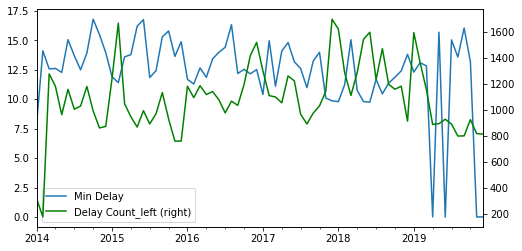

In [103]:
dfmonthav['Min Delay'].plot(legend=True)
# df.B.plot(secondary_y=True, style='g')
dfmonthav['Delay Count_left'].plot(secondary_y=True, style='g',legend=True)

In [104]:
#ax.set_ylabel('Average Delay')
#ax.right_ax.set_ylabel('Number of delays')
plt.rcParams["figure.figsize"] = [8,4]
plt.show()

# Time Series Forecasting
**Trend** - Trend shows the variation in the output as time increases, often in a non-linear fashion. 

**Level** - The baseline value for a time series.

**Seasonality** - is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal - from https://www.investopedia.com/terms/s/seasonality.asp

**Noise** - Random variation in the data.

In [105]:
dfmonthav.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-31 to 2019-12-31
Freq: M
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Min Delay               72 non-null     float64       
 1   Report Date Time        72 non-null     datetime64[ns]
 2   Delay Count_left        72 non-null     int64         
 3   Report Date Time_right  72 non-null     datetime64[ns]
 4   Delay Count_right       72 non-null     int64         
 5   Report Date Time_right  72 non-null     datetime64[ns]
 6   Month                   72 non-null     int64         
dtypes: datetime64[ns](3), float64(1), int64(3)
memory usage: 4.5 KB


In [106]:
# add a column to make scatter plot by month convenient
dfmonthav['Month'] = dfmonthav['Report Date Time'].dt.month
dfmonthav.head(20)

,Min Delay,Report Date Time,Delay Count_left,Report Date Time_right,Delay Count_right,Report Date Time_right,Month
2014-01-31,7.862069,2014-01-31,319,2014-01-31,319,2014-01-31,1
2014-02-28,14.117978,2014-02-28,178,2014-02-28,178,2014-02-28,2
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,1278,2014-03-31,3
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,1182,2014-04-30,4
2014-05-31,12.280083,2014-05-31,964,2014-05-31,964,2014-05-31,5
2014-06-30,15.066437,2014-06-30,1159,2014-06-30,1159,2014-06-30,6
2014-07-31,13.701789,2014-07-31,1006,2014-07-31,1006,2014-07-31,7
2014-08-31,12.505335,2014-08-31,1031,2014-08-31,1031,2014-08-31,8
2014-09-30,13.930567,2014-09-30,1181,2014-09-30,1181,2014-09-30,9
2014-10-31,16.803625,2014-10-31,993,2014-10-31,993,2014-10-31,10


In [107]:
dfmonthav.head(20)

,Min Delay,Report Date Time,Delay Count_left,Report Date Time_right,Delay Count_right,Report Date Time_right,Month
2014-01-31,7.862069,2014-01-31,319,2014-01-31,319,2014-01-31,1
2014-02-28,14.117978,2014-02-28,178,2014-02-28,178,2014-02-28,2
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,1278,2014-03-31,3
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,1182,2014-04-30,4
2014-05-31,12.280083,2014-05-31,964,2014-05-31,964,2014-05-31,5
2014-06-30,15.066437,2014-06-30,1159,2014-06-30,1159,2014-06-30,6
2014-07-31,13.701789,2014-07-31,1006,2014-07-31,1006,2014-07-31,7
2014-08-31,12.505335,2014-08-31,1031,2014-08-31,1031,2014-08-31,8
2014-09-30,13.930567,2014-09-30,1181,2014-09-30,1181,2014-09-30,9
2014-10-31,16.803625,2014-10-31,993,2014-10-31,993,2014-10-31,10


In [119]:
# scatter plot to show mean delay in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Min Delay')
plt.show()

Exception: Data must be 1-dimensional

In [109]:
# scatter plot to show delay count in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Delay Count')
plt.show()

Exception: Data must be 1-dimensional

# Trend Analysis

Use the built-in Pandas rolling function to smooth the data.

For trend analysis, we use smoothing techniques. 
- In statistics smoothing a data set means to create an approximating function that attempts to capture important patterns in the data, while leaving out noise or other fine-scale structures/rapid phenomena. 
- In smoothing, the data points of a signal are modified so individual points (presumably because of noise) are reduced, and points that are lower than the adjacent points are increased leading to a smoother signal. 

We implement smoothing by taking moving averages. [Exponential moving average](https://www.investopedia.com/terms/e/ema.asp) is frequently used to compute smoothed function.

In [110]:
mean_delay = dfmonthav[['Min Delay']]
count_delay = dfmonthav[['Delay Count']]

KeyError: "None of [Index(['Delay Count'], dtype='object')] are in the [columns]"

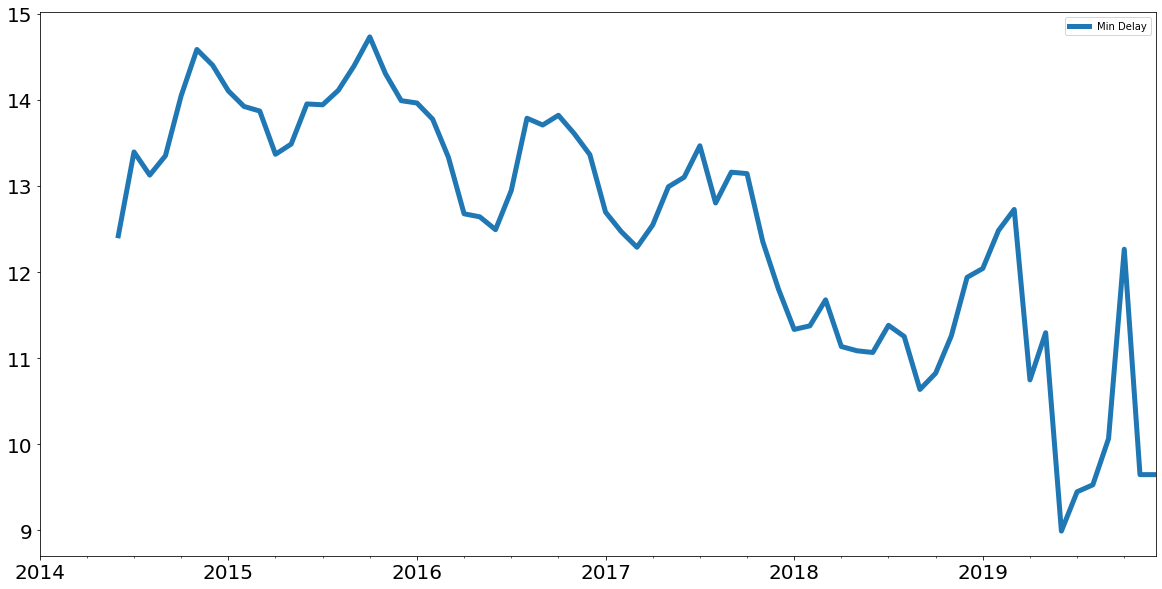

In [111]:
mean_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

In [112]:
count_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

NameError: name 'count_delay' is not defined

# Seasonality Analysis

Two examples of seasonality analysis algorithms are:

[Using 1st discrete difference of object](https://machinelearningmastery.com/difference-time-series-dataset-python/)

[Periodicity and Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

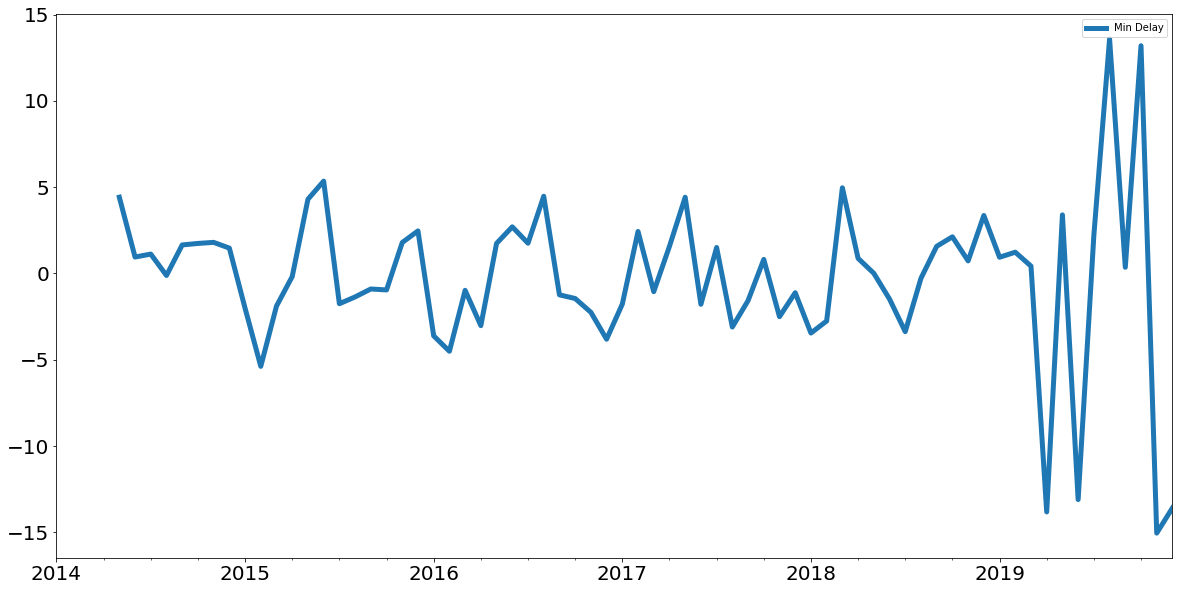

In [113]:
# using 1st discrete difference of object
# This gives us idea about variation of data for a period of time.
mean_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

In [114]:
count_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

NameError: name 'count_delay' is not defined

Auto correlation is the most famous way to understand seasonal variation till now. We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.In this plot vertical axis is represented by the following equations:-

> $C_n = \sum_{t = 1}^{n - h} (y(t) - \hat{y}) (y(t + n) - \hat{y}) / n$

> $C_0 = \sum_{t = 1}^{n} (y(t) - \hat{y})^2 / n$

Horizontal axis represents time lag(previous time steps)  h

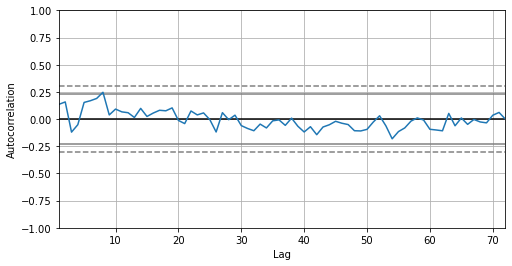

In [115]:
# mean_delay = dfmonthav[['Min Delay']]
# count_delay = dfmonthav[['Delay Count']]


pd.plotting.autocorrelation_plot(dfmonthav['Min Delay'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

In [116]:
pd.plotting.autocorrelation_plot(dfmonthav['Delay Count'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

KeyError: 'Delay Count'

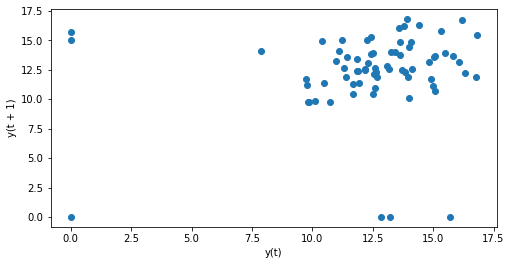

In [117]:
pd.plotting.lag_plot(dfmonthav['Min Delay'])
plt.show()

In [118]:
pd.plotting.lag_plot(dfmonthav['Delay Count'])
plt.show()

KeyError: 'Delay Count'